In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image

In [2]:
train_dir = '/content/drive/MyDrive/image_classification_data/seg_train'
test_dir = '/content/drive/MyDrive/image_classification_data/seg_test'
pred_dir = '/content/drive/MyDrive/image_classification_data/seg_pred'

In [3]:
transform = transforms.Compose([transforms.Resize((150, 150)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
# numbers are from ImageNet dataset

In [4]:
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
# ImageFolder asumes that there are sub_dirs and makes them the labels for the images

In [5]:
print("Training classes:", train_dataset.classes)
print("Testing classes:", test_dataset.classes)

Training classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Testing classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [6]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

Number of training samples: 14044
Number of testing samples: 3000


#Self Built CNN Model

In [8]:
class SimpleCNN(nn.Module):
  def __init__(self, num_classes=6):
    super(SimpleCNN, self).__init__()
    # in_chanels=3 because of RGB
    # kernel_size=3 is the size of the scanner that will scan the image
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(32)

    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(64)

    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.bn3 = nn.BatchNorm2d(128)

    # halve spatial dimensions every layer (width/height), prevent overfit
    self.pool = nn.MaxPool2d(2, 2)

    # input: 150x150 -> 75x75 -> 37x37 -> 18x18.
    self.fc1 = nn.Linear(128 * 18 * 18, 256)
    self.fc2 = nn.Linear(256, num_classes)


  def forward(self, x):
    x = self.pool(F.relu(self.bn1(self.conv1(x))))
    x = self.pool(F.relu(self.bn2(self.conv2(x))))
    x = self.pool(F.relu(self.bn3(self.conv3(x))))

    # reshape from 3D for nn.Linear
    x = x.view(x.size(0), -1)

    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [15]:
model = SimpleCNN(num_classes=6)

In [16]:
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=41472, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=6, bias=True)
)


In [17]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("Using GPU")
else:
  device = torch.device("cpu")
  print("Using CPU")
model.to(device)

criterion = nn.CrossEntropyLoss()  # uses softmax on the output, nad NLLLoss to measure how well the predicted match true labels
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10  # might need to be higher

Using GPU


In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # training loop
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # backpropagation, computes the gradients
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        # compute training accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total * 100

    model.eval() # disables dropout, batch normalization
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    # using torch.no_grad will save memory and computation power,
    # while ensuring no gradients are computed, and weights aren't updated.
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(test_loader.dataset)
    val_acc = val_correct / val_total * 100

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%")
    print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

In [ ]:
# save the entire model
torch.save(model.state_dict(), 'simple_cnn_model.pth')
print("Model saved successfully.")

Model saved successfully.


In [ ]:
def visualize_predictions(model, image_files, num_images=20):
  model.eval()
  fig, axes = plt.subplots(4, 5, figsize=(15, 12))  # 4 rows 5 columns
  axes = axes.flatten()

  class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

  with torch.no_grad():
      for i, file_path in enumerate(image_files[:num_images]):
          image = Image.open(file_path).convert("RGB")
          input_tensor = transform(image).unsqueeze(0).to(device)

          output = model(input_tensor)
          _, predicted = torch.max(output, 1)
          predicted_label = class_names[predicted.item()]

          axes[i].imshow(image)
          axes[i].axis('off')
          axes[i].set_title(predicted_label, fontsize=12)

  plt.tight_layout()
  plt.show()

In [ ]:
import os

In [ ]:
seg_pred_path = "/content/drive/MyDrive/image_classification_data/seg_pred"

image_files = [os.path.join(seg_pred_path, f) for f in os.listdir(seg_pred_path) if f.endswith(".jpg")]

image_files.sort()

transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

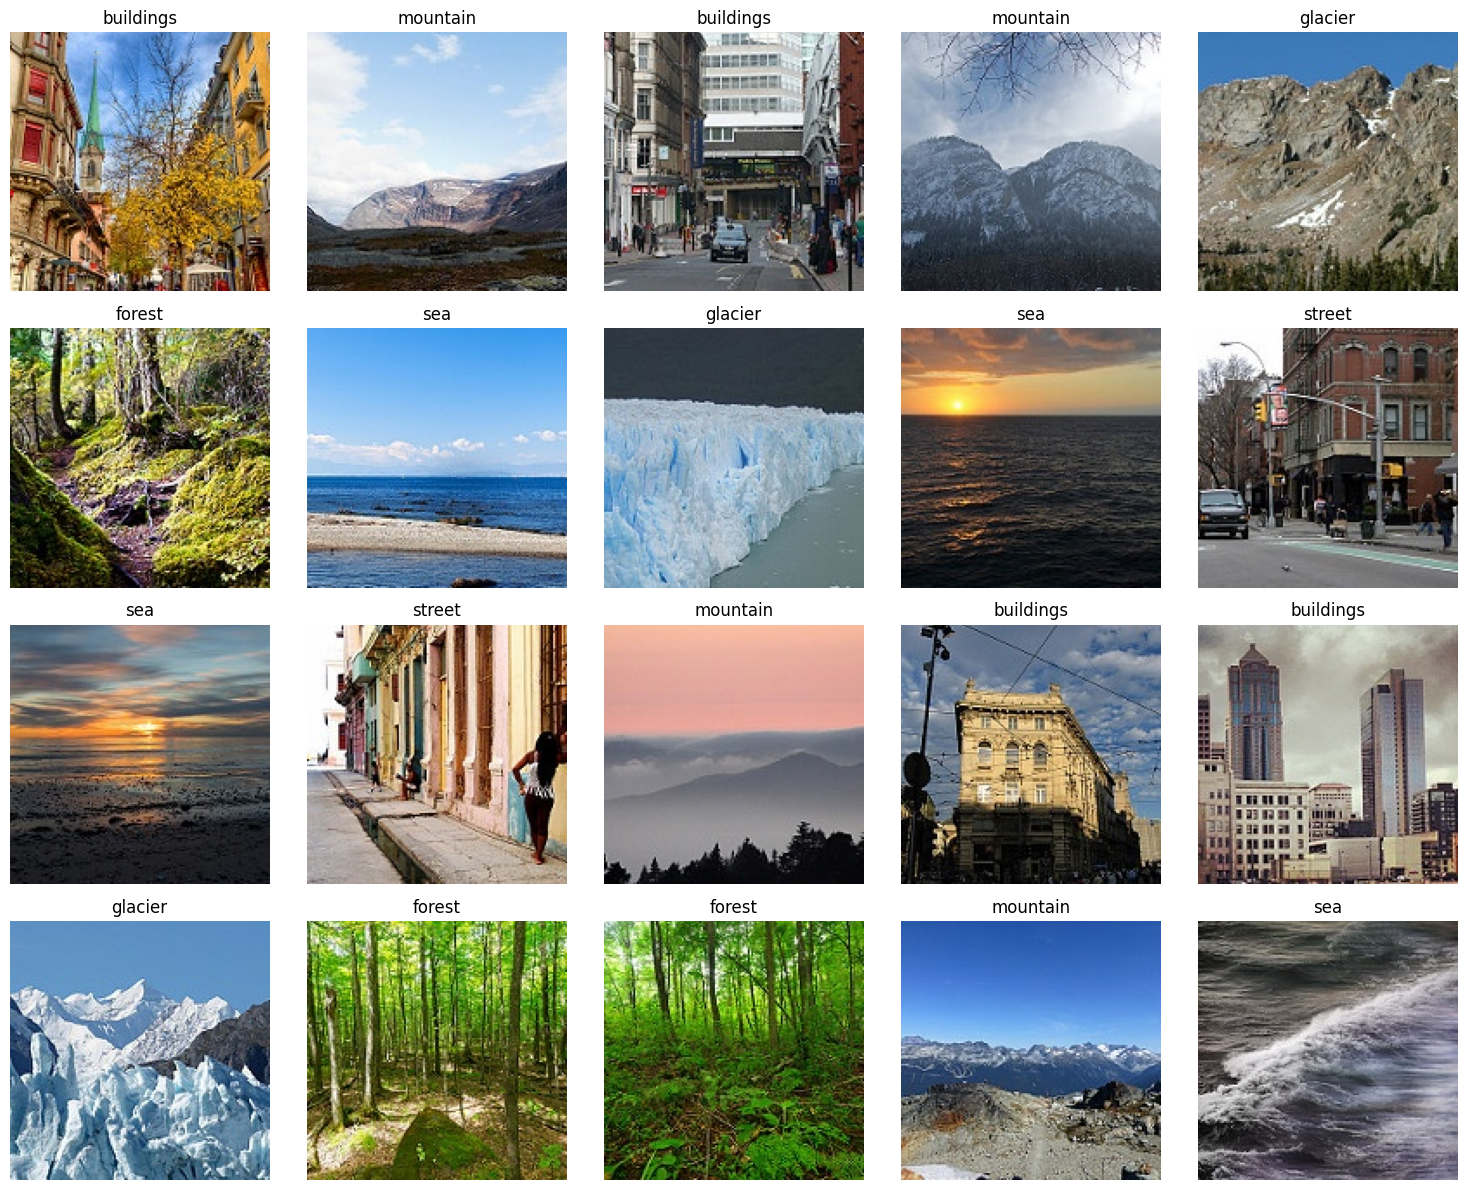

In [ ]:
visualize_predictions(model, image_files, num_images=20)

In [ ]:
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
def visualize_predictions_with_precentage(model, image_files, num_images=20):
  model.eval()
  fig, axes = plt.subplots(5, 4, figsize=(15, 16))  # 4 rows 5 columns
  axes = axes.flatten()

  with torch.no_grad():
      for i, file_path in enumerate(image_files[:num_images]):
          image = Image.open(file_path).convert("RGB")
          input_tensor = transform(image).unsqueeze(0).to(device)

          output = model(input_tensor)
          probabilities = F.softmax(output, dim=1).cpu().numpy()[0]

          # get predicted label and its probability
          predicted_idx = torch.argmax(output, 1).item()
          predicted_label = class_names[predicted_idx]
          predicted_prob = probabilities[predicted_idx]

          # format probabilities for display
          prob_text = "\n".join([f"{class_names[j]}: {probabilities[j]:.2f}" for j in range(len(class_names))])

          axes[i].imshow(image)
          axes[i].axis('off')
          axes[i].set_title(f"{predicted_label} ({predicted_prob:.2f})", fontsize=12)

          # add probabilities as text below image
          axes[i].text(0, 160, prob_text, fontsize=10, color="black", bbox=dict(facecolor='white', alpha=0.8))

  plt.tight_layout()
  plt.show()

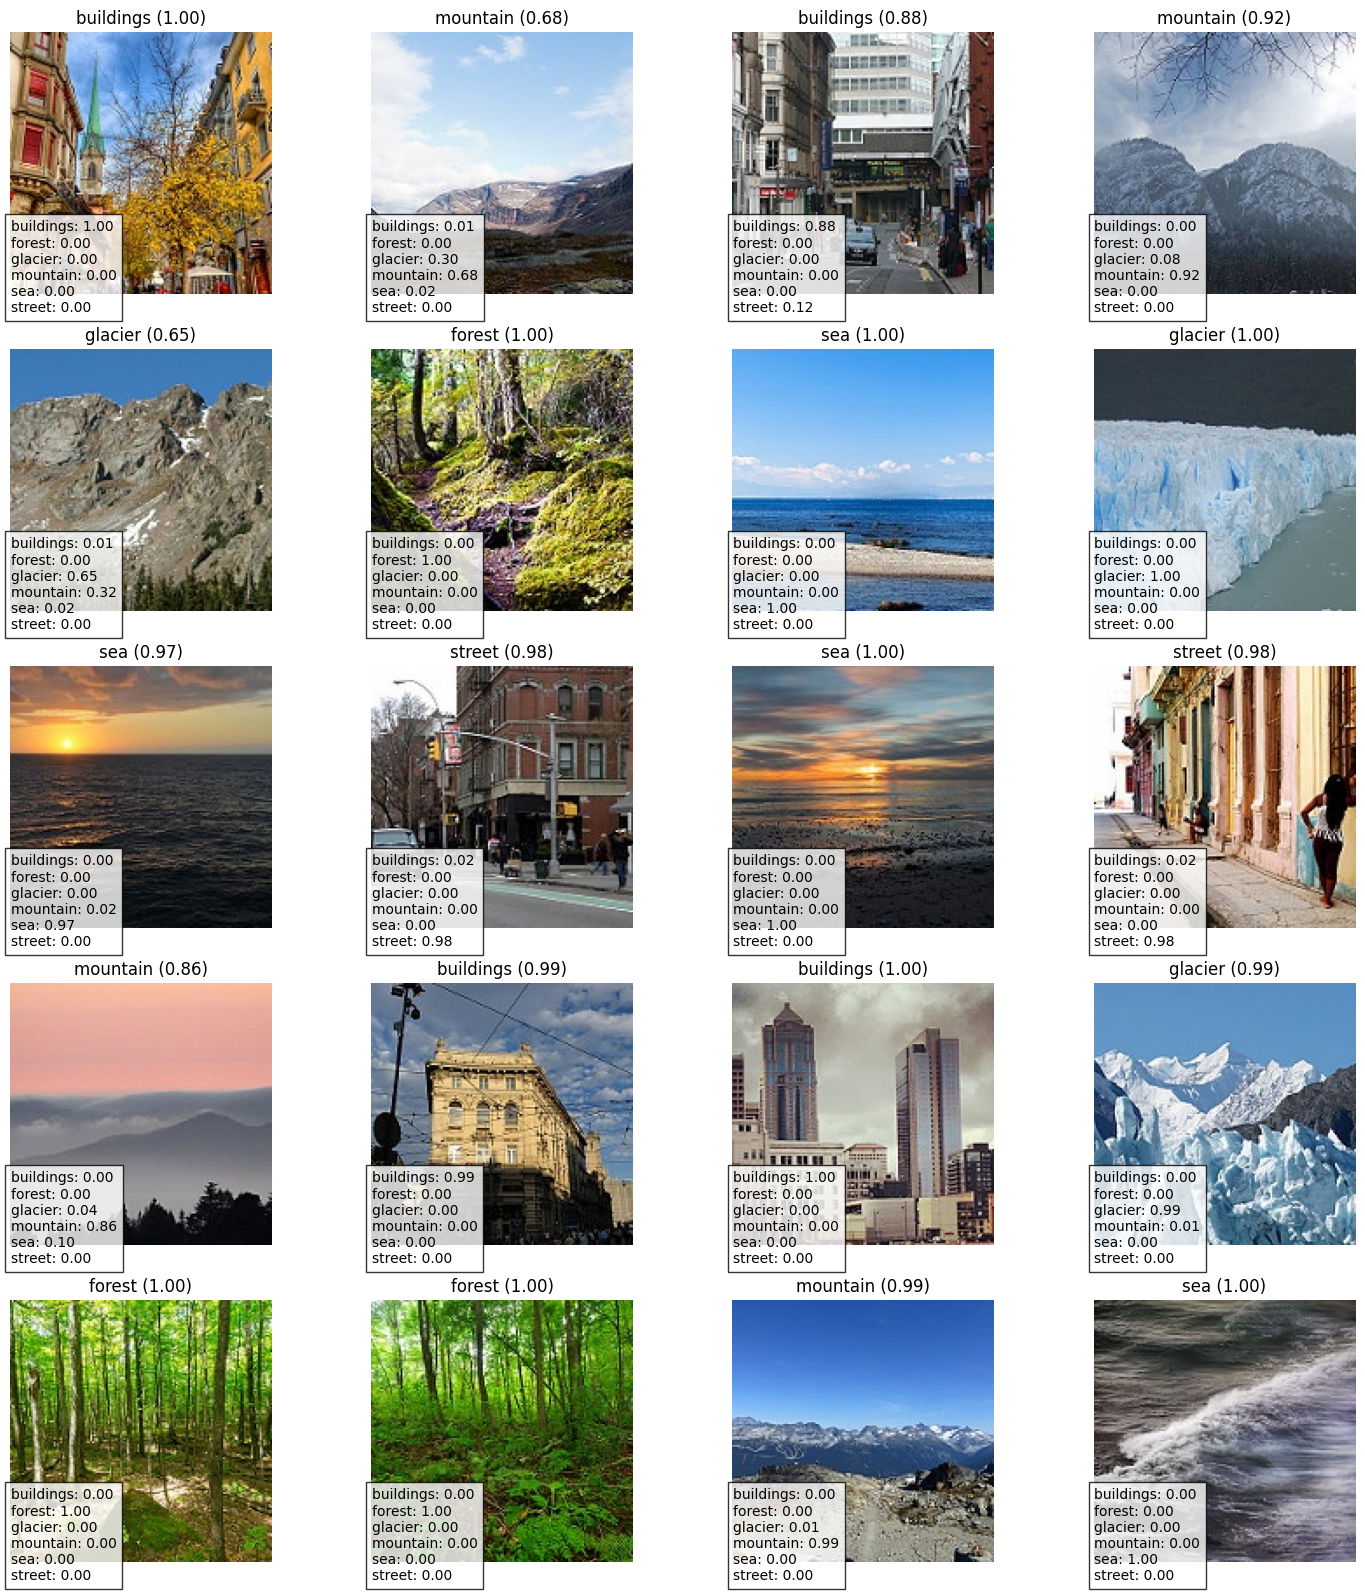

In [ ]:
visualize_predictions_with_precentage(model, image_files, num_images=20)